In [2]:
# import  packages

import pandas as pd
import numpy as np
import requests
import json
import argparse
import collections
import csv
from glob import glob
import matplotlib.pyplot as plt
import time
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
from sklearn import tree

import json
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict



#from time import time
#from IPython.display import clear_output
start_time = time.time()


%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (12, 8)

In [1]:
# To activate gpu ram
import tensorflow as tf

device_list = tf.test.gpu_device_name()
if device_list != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'. format(device_list))

Found GPU at: /device:GPU:0


In [3]:
# load and mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# To add SQLite db funtionanities v1
def make_query(sel):
    """Query database"""
    c = db.cursor().execute(sel)
    return c.fetchall()

def make_frame(list_of_tuples=None, legend=[], query=None):
    """
    Returns DataFrame from a query or result of query
    """
    framelist=[]
    if list_of_tuples is None:
        if query is None:
            print("Error: No query made")
            return
        list_of_tuples = make_query(query)
        
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist))

db = sq3.connect('/content/drive/MyDrive/Colab Notebooks/yelp_database.db')

In [5]:
# Looking at columns of 'reviews' table
make_query("PRAGMA table_info(reviews)")

[(0, 'review_id', 'VARCHAR', 0, None, 1),
 (1, 'user_id', 'INTEGER', 0, None, 0),
 (2, 'business_id', 'INTEGER', 0, None, 0),
 (3, 'stars', 'FLOAT', 0, None, 0),
 (4, 'useful', 'INTEGER', 0, None, 0),
 (5, 'funny', 'INTEGER', 0, None, 0),
 (6, 'cool', 'INTEGER', 0, None, 0),
 (7, 'text', 'VARCHAR', 0, None, 0),
 (8, 'date', 'TIMESTAMP', 0, None, 0)]

In [6]:
# Looking at columns of 'reviews' table
make_query("PRAGMA table_info(users)")

[(0, 'user_id', 'INTEGER', 1, None, 1),
 (1, 'name', 'VARCHAR', 0, None, 0),
 (2, 'review_count', 'INTEGER', 0, None, 0),
 (3, 'yelping_since', 'TIMESTAMP', 0, None, 0),
 (4, 'useful', 'INTEGER', 0, None, 0),
 (5, 'funny', 'INTEGER', 0, None, 0),
 (6, 'cool', 'INTEGER', 0, None, 0),
 (7, 'elite', 'VARCHAR', 0, None, 0),
 (8, 'friends', 'VARCHAR', 0, None, 0),
 (9, 'fans', 'INTEGER', 0, None, 0),
 (10, 'average_stars', 'FLOAT', 0, None, 0),
 (11, 'compliment_hot', 'INTEGER', 0, None, 0),
 (12, 'compliment_more', 'INTEGER', 0, None, 0),
 (13, 'compliment_profile', 'INTEGER', 0, None, 0),
 (14, 'compliment_cute', 'INTEGER', 0, None, 0),
 (15, 'compliment_list', 'INTEGER', 0, None, 0),
 (16, 'compliment_note', 'INTEGER', 0, None, 0),
 (17, 'compliment_plain', 'INTEGER', 0, None, 0),
 (18, 'compliment_cool', 'INTEGER', 0, None, 0),
 (19, 'compliment_funny', 'INTEGER', 0, None, 0),
 (20, 'compliment_writer', 'INTEGER', 0, None, 0),
 (21, 'compliment_photos', 'INTEGER', 0, None, 0)]

In [7]:
# Looking at columns of 'reviews' table
make_query("PRAGMA table_info(businesses)")

[(0, 'business_id', 'INTEGER', 1, None, 1),
 (1, 'name', 'VARCHAR', 0, None, 0),
 (2, 'address', 'VARCHAR', 0, None, 0),
 (3, 'city', 'VARCHAR', 0, None, 0),
 (4, 'state', 'VARCHAR', 0, None, 0),
 (5, 'postal_code', 'VARCHAR', 0, None, 0),
 (6, 'latitude', 'FLOAT', 0, None, 0),
 (7, 'longitude', 'FLOAT', 0, None, 0),
 (8, 'stars', 'FLOAT', 0, None, 0),
 (9, 'review_count', 'INTEGER', 0, None, 0),
 (10, 'is_open', 'BOOLEAN', 0, None, 0),
 (11, 'categories', 'VARCHAR', 0, None, 0),
 (12, 'RestaurantsDelivery', 'BOOLEAN', 0, None, 0),
 (13, 'OutdoorSeating', 'BOOLEAN', 0, None, 0),
 (14, 'BusinessAcceptsCreditCards', 'BOOLEAN', 0, None, 0),
 (15, 'BusinessParking', 'BOOLEAN', 0, None, 0),
 (16, 'BikeParking', 'BOOLEAN', 0, None, 0),
 (17, 'RestaurantsPriceRange2', 'BOOLEAN', 0, None, 0),
 (18, 'RestaurantsTakeOut', 'BOOLEAN', 0, None, 0),
 (19, 'ByAppointmentOnly', 'BOOLEAN', 0, None, 0),
 (20, 'WiFi', 'BOOLEAN', 0, None, 0),
 (21, 'Alcohol', 'BOOLEAN', 0, None, 0),
 (22, 'Caters', 'BOOLE

In [8]:
q = make_query("SELECT user_id, business_id, stars, useful FROM reviews")
n = make_query("SELECT user_id, review_count, friends, yelping_since FROM users")
b = pd.read_sql('SELECT * FROM businesses', db)

ratings_df0 = make_frame(q, legend=['user_id', 'business_id', 'stars', 'useful'])
users_df0 = make_frame(n, legend=['user_id', 'review_count', 'friends', 'yelping_since'])
businesses_df0 = pd.DataFrame(data=b) #, columns=['a', 'b', 'c'])

del q, n, b

ratings_df0.head()
users_df0.head()
businesses_df0.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,AgesAllowed,DietaryRestrictions,HairSpecializesIn,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,0,0,0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
1,1,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,0,0,0,None,None,14:0-22:0,16:0-22:0,12:0-22:0,12:0-22:0,12:0-18:0
2,2,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,0,0,0,0:0-0:0,6:0-22:0,6:0-22:0,6:0-22:0,9:0-0:0,9:0-22:0,8:0-22:0
3,3,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,...,0,0,0,None,None,None,None,None,None,None
4,4,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,0,0,0,0:0-0:0,6:0-21:0,6:0-21:0,6:0-16:0,6:0-16:0,6:0-17:0,6:0-21:0


In [9]:
print(ratings_df0.head(), ratings_df0.info())
print('\br')
print('\br')

print(users_df0.head(),users_df0.info())
print('\br')
print('\br')

print(businesses_df0.head(), businesses_df0.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5126276 entries, 0 to 5126275
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   business_id  int64  
 2   stars        float64
 3   useful       int64  
dtypes: float64(1), int64(3)
memory usage: 156.4 MB
   user_id  business_id  stars  useful
0   124234          799    3.0       0
1    98159         5659    3.0       0
2   164430         2729    5.0       1
3   150111         2626    4.0       1
4   132438         1186    1.0       1 None
r
r
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   review_count   int64 
 2   friends        object
 3   yelping_since  object
dtypes: int64(2), object(2)
memory usage: 60.7+ MB
   user_id  review_count    friends        yelping_since
0        0           585     [1625]  2007-01-25 16:47

In [10]:
print(ratings_df0.shape)
print(users_df0.shape)
print(businesses_df0.shape)

(5126276, 4)
(1987897, 4)
(64629, 58)


In [11]:
#Reducing the data, and merging the columns, while removing unused columns
ratings_df0 = ratings_df0
users_df0 = users_df0
users_df0["friends"].str.removeprefix("[")
users_df0["friends"].str.removesuffix("]")
businesses_df0 = businesses_df0.drop(columns = ['name', 'address', 'postal_code', 'review_count', 'city', 'state', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1)
businesses_df0 = businesses_df0

print(ratings_df0.shape)
print(users_df0.shape)
print(businesses_df0.shape)

TT = ratings_df0.merge(users_df0, how = 'left', on = 'user_id')
TT.fillna(value='0',axis='columns', inplace=True)
TT = TT.merge(businesses_df0, how = 'left', on = 'business_id')

(5126276, 4)
(1987897, 4)
(64629, 45)


In [12]:
RU = TT[:50000]
print(RU.info())
print(RU.shape)
RU.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     50000 non-null  object 
 1   business_id                 50000 non-null  object 
 2   stars_x                     50000 non-null  object 
 3   useful                      50000 non-null  object 
 4   review_count                50000 non-null  object 
 5   friends                     50000 non-null  object 
 6   yelping_since               50000 non-null  object 
 7   latitude                    50000 non-null  float64
 8   longitude                   50000 non-null  float64
 9   stars_y                     50000 non-null  float64
 10  is_open                     50000 non-null  int64  
 11  categories                  50000 non-null  object 
 12  RestaurantsDelivery         50000 non-null  int64  
 13  OutdoorSeating              500

,user_id,business_id,stars_x,useful,review_count,friends,yelping_since,latitude,longitude,stars_y,...,BestNights,BYOB,Corkage,BYOBCorkage,AcceptsInsurance,RestaurantsCounterService,Open24Hours,AgesAllowed,DietaryRestrictions,HairSpecializesIn
0,124234,799,3.0,0,33,[],2016-01-13 17:20:44,40.210196,-75.223639,3.0,...,0,0,0,0,0,0,0,0,0,0
1,98159,5659,3.0,0,1332,[252556],2012-09-04 23:57:25,32.207233,-110.980864,3.5,...,0,0,0,0,0,0,0,0,0,0
2,164430,2729,5.0,1,9,[],2014-01-17 19:20:57,40.079848,-75.025080,4.0,...,0,0,0,0,0,0,0,0,0,0
3,150111,2626,4.0,1,126,[],2008-04-17 13:39:54,29.962102,-90.087958,4.0,...,0,0,0,0,0,0,0,0,0,0
4,132438,1186,1.0,1,4,[628718],2014-06-15 18:44:27,39.938013,-75.148131,4.0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# df_combine =  df_combine.drop(columns = ['review_id', 'user_id', 'business_id', 'stars_x', 'useful_x', 'funny',
#       'cool_x', 'text', 'date', 'day', 'month', 'year', 'hour', 'minute',
#       'second', 'name', 'address', 'city', 'state',
#       'postal_code', 'latitude', 'longitude', 'stars_y', 'bus_review_count',
#       'is_open', 'categories',  'OutdoorSeating',
#       'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking',
#       'RestaurantsPriceRange2',  'ByAppointmentOnly',
#        'Alcohol', 'Caters', 'WheelchairAccessible', 'GoodForKids',
#       'RestaurantsAttire', 'RestaurantsReservations', 'Ambience', 'CoatCheck',
#       'DogsAllowed', 'RestaurantsTableService', 'RestaurantsGoodForGroups',
#       'HasTV', 'HappyHour', 'DriveThru', 'GoodForMeal',
#       'BusinessAcceptsBitcoin', 'Smoking', 'Music', 'GoodForDancing',
#       'BestNights', 'BYOB', 'Corkage', 'BYOBCorkage', 'AcceptsInsurance',
#       'RestaurantsCounterService', 'Open24Hours', 'AgesAllowed',
#       'DietaryRestrictions', 'HairSpecializesIn', 'Monday', 'Tuesday',
#       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
#       'user_review_count', 'yelping_since', 'useful_y', 'cool_y',
#       'user_average_stars'
#       ])

# df_combine.head()

In [13]:
RU['categories'].unique()

array(['Restaurants, Breakfast & Brunch, Food, Juice Bars & Smoothies, American (New), Coffee & Tea, Sandwiches',
       'Restaurants, Breakfast & Brunch',
       'Halal, Pakistani, Restaurants, Indian', ...,
       'American (Traditional), Vegetarian, Restaurants',
       'Grocery, Fashion, Drugstores, Food, Shopping, Department Stores',
       'Bars, American (Traditional), Restaurants, Dive Bars, Nightlife, Irish Pub'],
      dtype=object)

In [14]:
# Import label encoder
from sklearn import preprocessing
  

# Select the columns to be encoded and the target feature
 #cat_cols = ['RestaurantsDelivery',	'WiFi',	'NoiseLevel',	'RestaurantsTakeOut']
 #Target = 'above_average'

# Apply label encoding to each categorical column
label_encoder = preprocessing.LabelEncoder()
RU['categories'] = label_encoder.fit_transform(RU['categories'])

RU['categories']
RU.info()
RU.head()
RU.shape

# Select the encoded columns and the target feature
# X = df_combine[[col + '_encoded' for col in cat_cols]]
# y = df_combine[Target]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     50000 non-null  object 
 1   business_id                 50000 non-null  object 
 2   stars_x                     50000 non-null  object 
 3   useful                      50000 non-null  object 
 4   review_count                50000 non-null  object 
 5   friends                     50000 non-null  object 
 6   yelping_since               50000 non-null  object 
 7   latitude                    50000 non-null  float64
 8   longitude                   50000 non-null  float64
 9   stars_y                     50000 non-null  float64
 10  is_open                     50000 non-null  int64  
 11  categories                  50000 non-null  int64  
 12  RestaurantsDelivery         50000 non-null  int64  
 13  OutdoorSeating              500

<ipython-input-14-cd3f997e3130>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RU['categories'] = label_encoder.fit_transform(RU['categories'])


(50000, 51)

In [15]:
# add a column that is looks at if reviews are over 3.8 stars
RU['above_average'] = RU['stars_x'] > 3.8
print(RU['above_average'])

0        False
1        False
2         True
3         True
4        False
         ...  
49995     True
49996     True
49997    False
49998    False
49999     True
Name: above_average, Length: 50000, dtype: bool


<ipython-input-15-14f98b08e9fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RU['above_average'] = RU['stars_x'] > 3.8


In [16]:
#df_combine[df_combine.columns] = df_combine[df_combine.columns].apply(pd.to_numeric, errors='coerce')
#df_combine.head()


#abv = df_combine['above_average']
#abv = df_combine
#rev = df_combine.drop('above_average', axis = 1)



RU['user_id'] = RU['user_id'].astype('int')
RU['business_id'] = RU['business_id'].astype('int')
RU['useful'] = RU['useful'].astype('int')
RU['review_count'] = RU['review_count'].astype('int')
X = RU.drop(columns = ['stars_x', 'friends', 'yelping_since', 'above_average',
       'BusinessParking', 'RestaurantsPriceRange2', 'RestaurantsDelivery',
        'ByAppointmentOnly', 'BusinessAcceptsCreditCards', 'NoiseLevel',
        'Alcohol', 'Caters', 'WheelchairAccessible', 'GoodForKids',
       'RestaurantsAttire', 'RestaurantsReservations', 'Ambience', 'CoatCheck',
       'DogsAllowed', 'RestaurantsGoodForGroups', 'WiFi', 'RestaurantsTableService',
       'HasTV', 'DriveThru', 'GoodForMeal', 'RestaurantsTakeOut', 'useful',
       'BusinessAcceptsBitcoin', 'Smoking', 'Music', 'GoodForDancing',
       'BestNights', 'BYOB', 'Corkage', 'BYOBCorkage', 'AcceptsInsurance',
       'RestaurantsCounterService', 'Open24Hours', 'AgesAllowed',
       'DietaryRestrictions', 'HairSpecializesIn', 'HappyHour'], axis=1)



y = RU['above_average']
y = y.astype('int')
#y = rev.iloc[:5000]

#print(df_combine[:5])
#print(abv[:5])
#print(X[:5])
#print(y[:5])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # 70% training and 30% test

<ipython-input-16-0f971b6b7dfb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RU['user_id'] = RU['user_id'].astype('int')
<ipython-input-16-0f971b6b7dfb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RU['business_id'] = RU['business_id'].astype('int')
<ipython-input-16-0f971b6b7dfb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [17]:
# Lets import necessary packages for our deeper analysis and models.

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, confusion_matrix, roc_curve, roc_auc_score, auc, classification_report

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from itertools import product

from sklearn.model_selection import train_test_split
import time
import sys

from sklearn.model_selection import cross_val_score 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.model_selection import KFold

from scipy import spatial

Accuracy: 0.6338


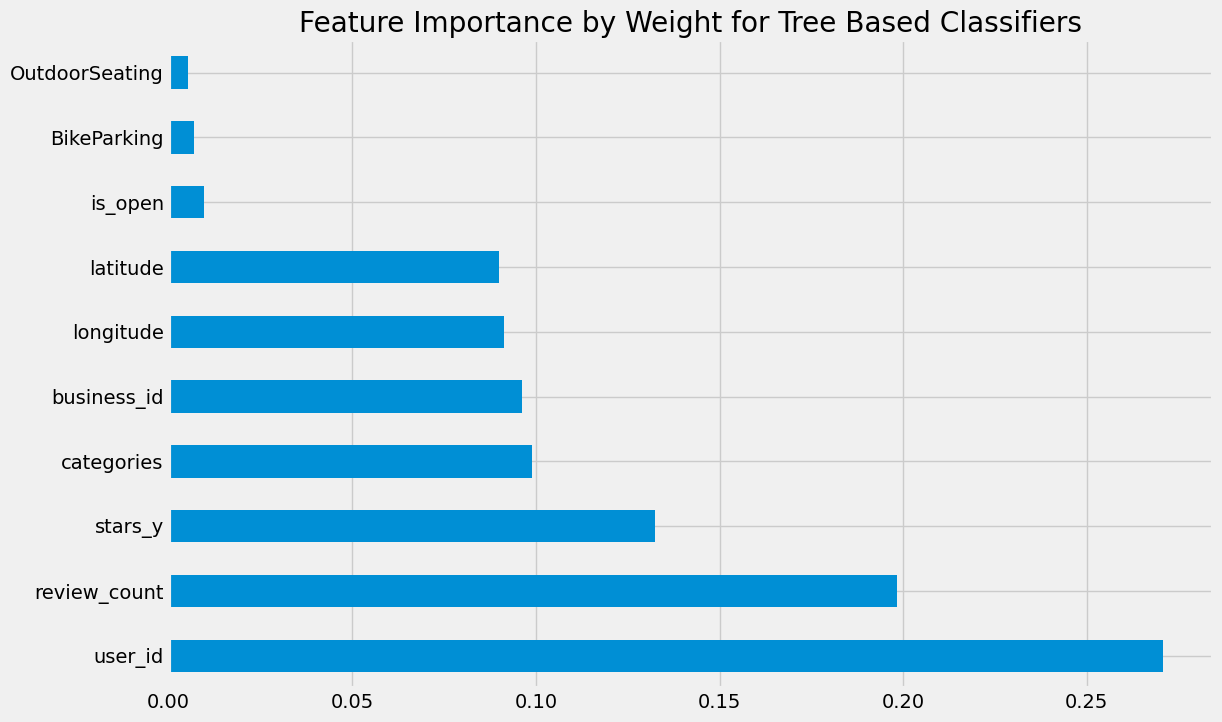

DecisionTreeClassifier               Classification Report 

              precision    recall  f1-score   support

           0       0.40      0.42      0.41      4579
           1       0.74      0.73      0.73     10421

    accuracy                           0.63     15000
   macro avg       0.57      0.57      0.57     15000
weighted avg       0.64      0.63      0.64     15000



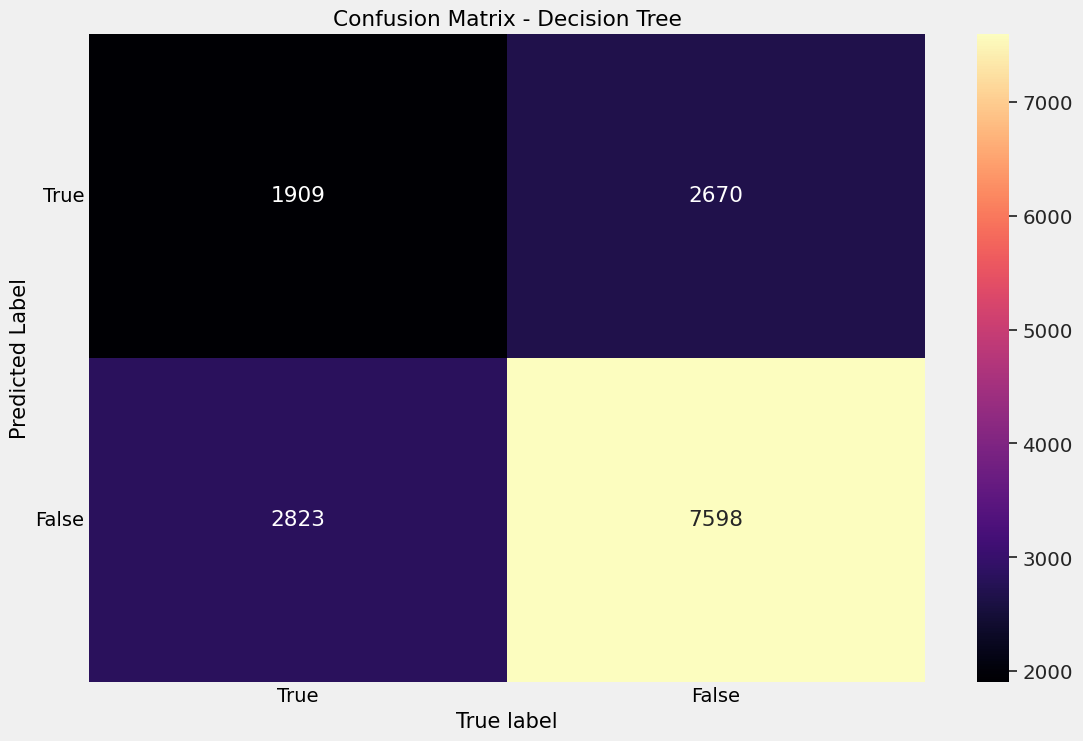

<Figure size 1000x700 with 0 Axes>

0.573003973216764

In [18]:
# LOOKING AT DECISION TREEE CLASSIER
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', title = 'Feature Importance by Weight for Tree Based Classifiers')
plt.show()
nb_cr = classification_report(y_test, y_pred)
print('DecisionTreeClassifier               Classification Report \n')
print(nb_cr)

# confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
# matrix_df = pd.DataFrame(confusion_matrix)#plot the result
# ax = plt.axes()
# sns.set(font_scale=1.3)
# plt.figure(figsize=(10,7))
# sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")#set axis titles
# ax.set_title('Confusion Matrix - Decision Tree')
# ax.set_xlabel("Predicted label", fontsize =15)
# ax.set_xticklabels(['False', 'True'])
# ax.set_ylabel("True Label", fontsize=15)
# ax.set_yticklabels(['False', 'True'], rotation = 0)
# plt.show()


confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(confusion_matrix)#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")#set axis titles
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("True label", fontsize =15)
ax.set_xticklabels(['True', 'False'])
ax.set_ylabel("Predicted Label", fontsize=15)
ax.set_yticklabels(['True', 'False'], rotation = 0)
plt.show()


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

Accuracy: 0.6762


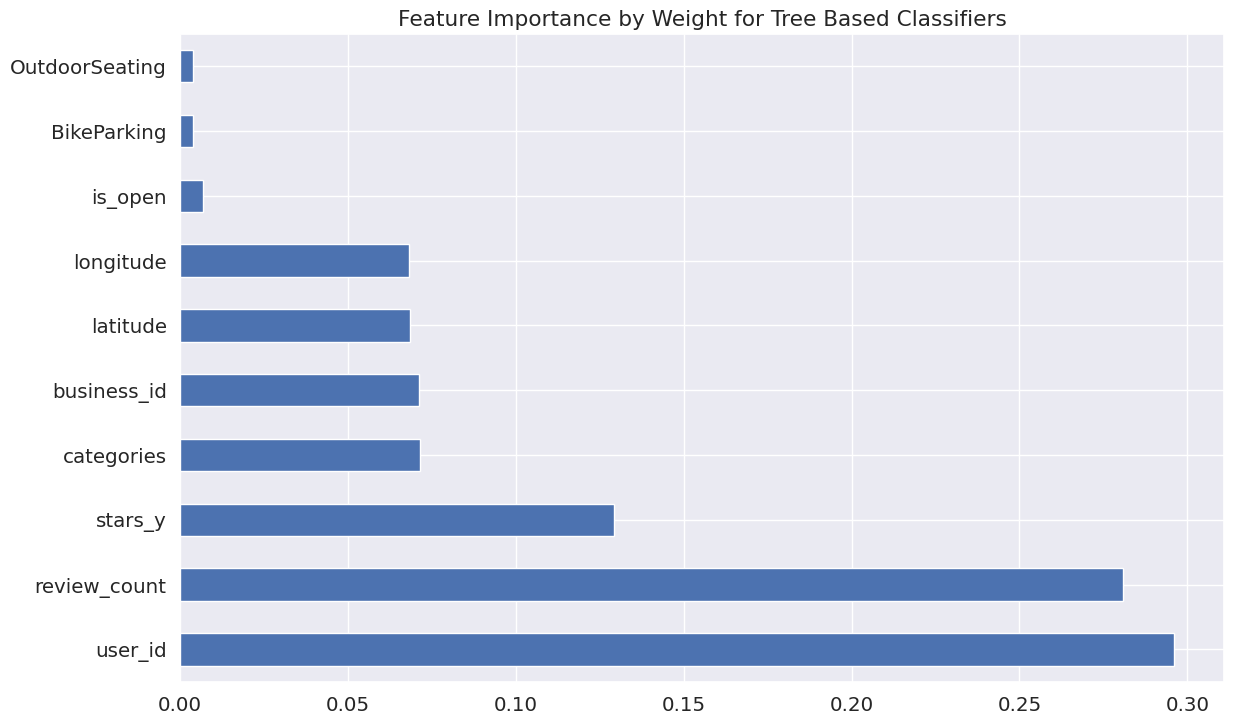

ExtraTreesClassifier               Classification Report 

              precision    recall  f1-score   support

           0       0.46      0.38      0.42      4579
           1       0.75      0.80      0.78     10421

    accuracy                           0.68     15000
   macro avg       0.61      0.59      0.60     15000
weighted avg       0.66      0.68      0.67     15000



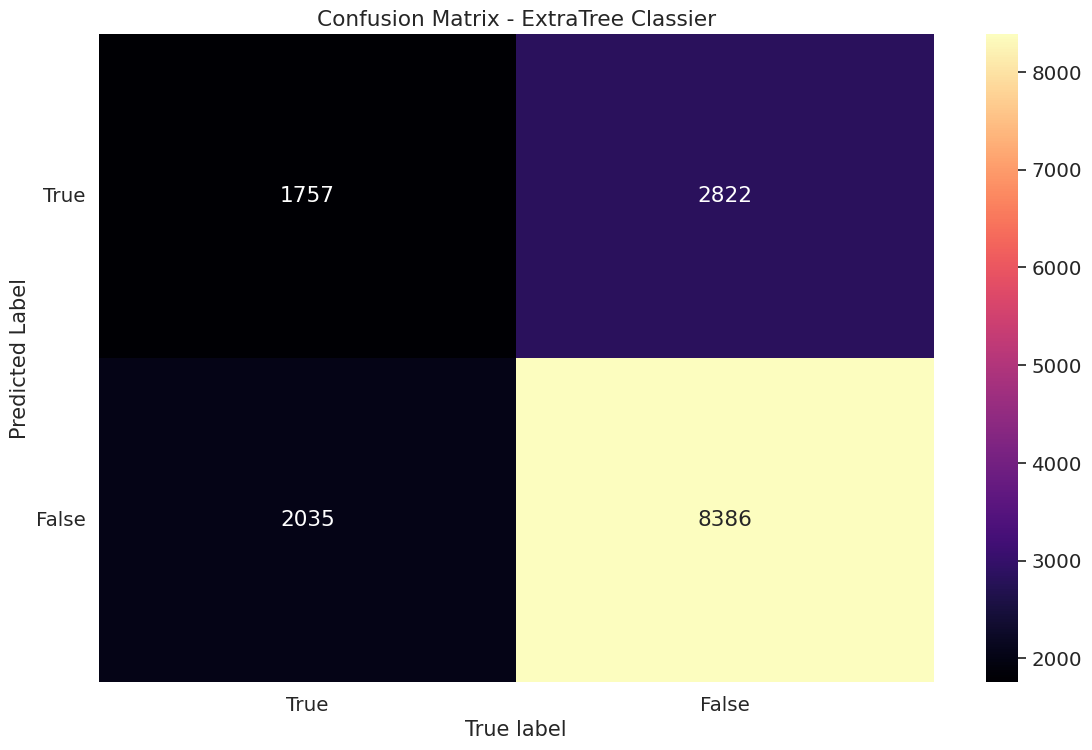

<Figure size 1000x700 with 0 Axes>

0.5942147346022684

In [19]:
# LOOKING AT EXTRA TREES CLASSIER
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', title = 'Feature Importance by Weight for Tree Based Classifiers')
plt.show()
nb_cr = classification_report(y_test, y_pred)
print('ExtraTreesClassifier               Classification Report \n')
print(nb_cr)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(confusion_matrix)#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")#set axis titles
ax.set_title('Confusion Matrix - ExtraTree Classier')
ax.set_xlabel("True label", fontsize =15)
ax.set_xticklabels(['True', 'False'])
ax.set_ylabel("Predicted Label", fontsize=15)
ax.set_yticklabels(['True', 'False'], rotation = 0)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

Accuracy: 0.6067333333333333
KNeighborsClassifier     Classification Report 

              precision    recall  f1-score   support

           0       0.30      0.22      0.26      4579
           1       0.69      0.78      0.73     10421

    accuracy                           0.61     15000
   macro avg       0.50      0.50      0.50     15000
weighted avg       0.58      0.61      0.59     15000



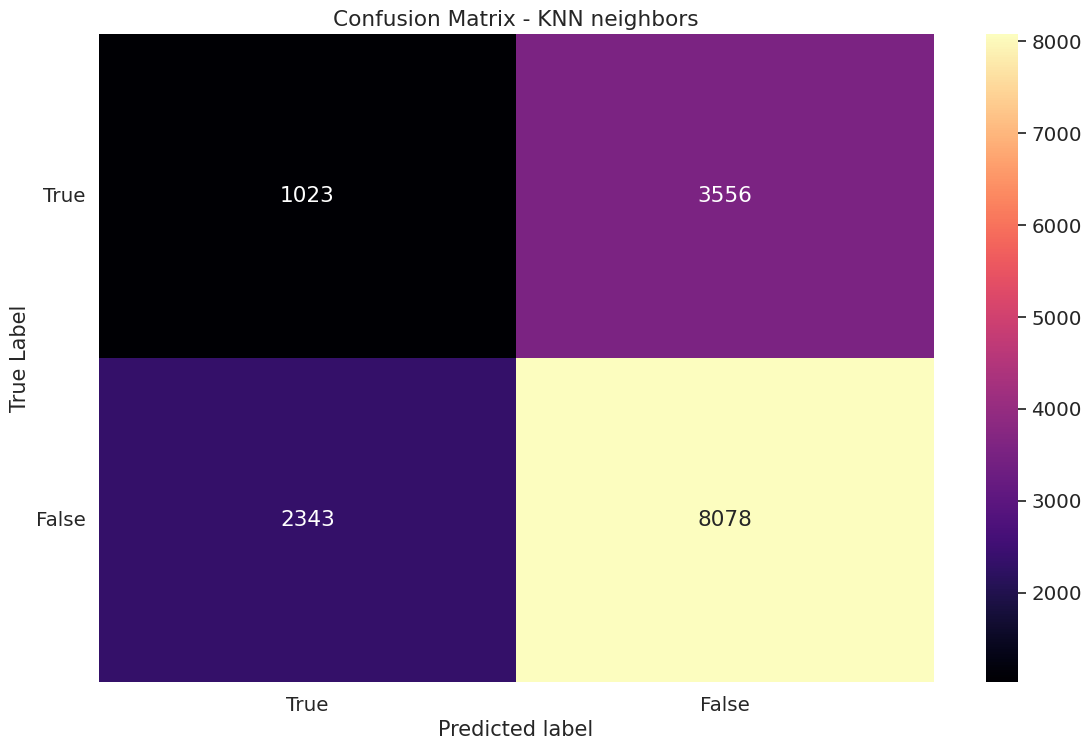

<Figure size 1000x700 with 0 Axes>

0.49928837814868887

In [21]:
# LOOKING AT KNN CLASSIER
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_validate

#Create KNN Classifier
knn3 = KNeighborsClassifier(n_neighbors = 3)

#Train the model using the training sets
knn3.fit(X_train, y_train)

#Predict the response for test dataset
y_pred1 = knn3.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred1))

nb_cr = classification_report(y_test, y_pred1)
print('KNeighborsClassifier     Classification Report \n')
print(nb_cr)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(confusion_matrix)#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")#set axis titles
ax.set_title('Confusion Matrix - KNN')
ax.set_xlabel("True label", fontsize =15)
ax.set_xticklabels(['True', 'False'])
ax.set_ylabel("Predicted Label", fontsize=15)
ax.set_yticklabels(['True', 'False'], rotation = 0)
plt.show()


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

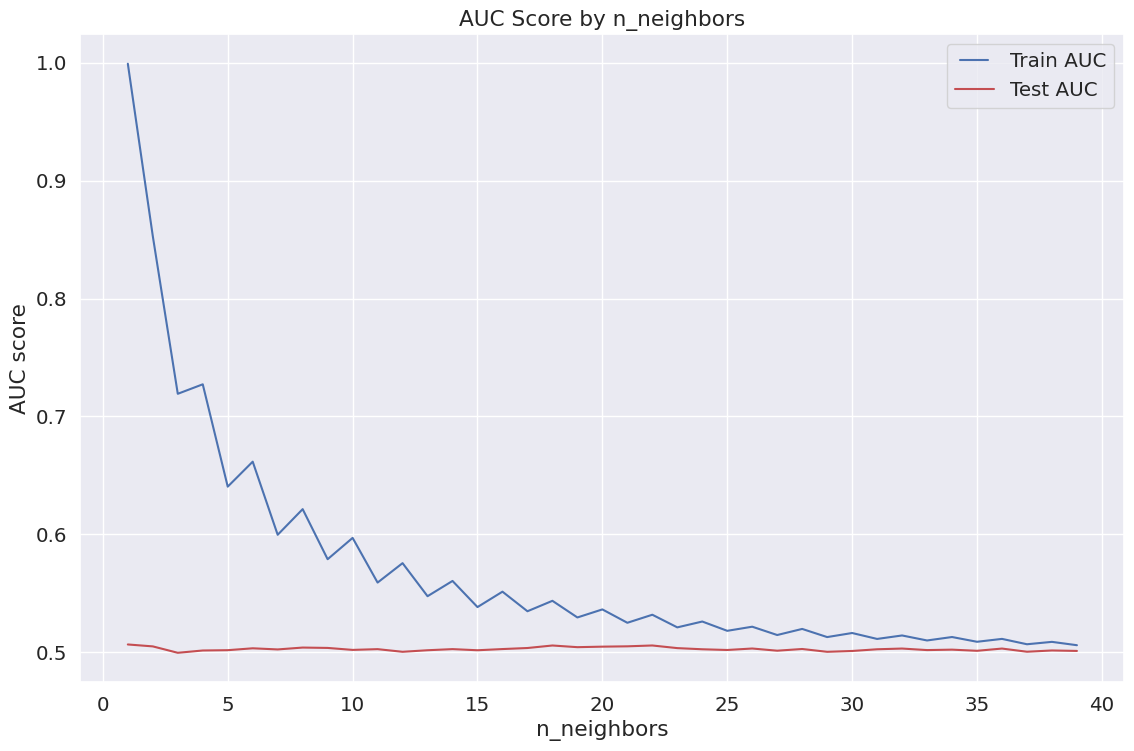

In [22]:
# LOOKING AT THE AUC_SCORE TO SEE IF THERE COULD BE UNDERFITTING
neighbors = list(range(1,40))

train_results = []
test_results = []

for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(neighbors, train_results, 'b', label = "Train AUC")
line2, = plt.plot(neighbors, test_results, 'r', label = "Test AUC")
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.title('AUC Score by n_neighbors')
plt.show()

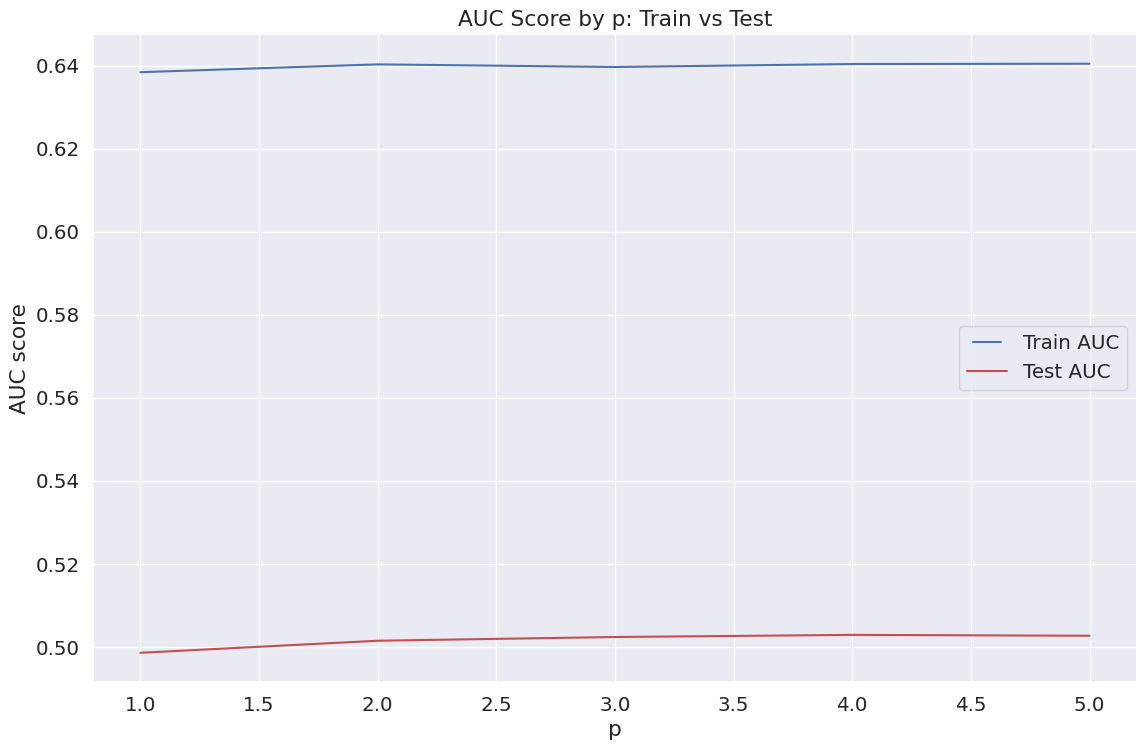

In [23]:
# LOOKING AT THE TRAIN VS TEST TO SEE IF THERE COULD BE OVRFITTING
distances = [1, 2, 3, 4, 5]
train_results = []
test_results = []
for p in distances:
    model = KNeighborsClassifier(p=p)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(distances, train_results, 'b', label="Train AUC")
line2, = plt.plot(distances, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('p')
plt.title('AUC Score by p: Train vs Test')
plt.show()

Accuracy: 0.6885333333333333
Number of mislabeled points out of a total 15000 points : 4672
Naive Bayes      Classification Report 

              precision    recall  f1-score   support

           0       0.36      0.02      0.05      4579
           1       0.70      0.98      0.81     10421

    accuracy                           0.69     15000
   macro avg       0.53      0.50      0.43     15000
weighted avg       0.59      0.69      0.58     15000



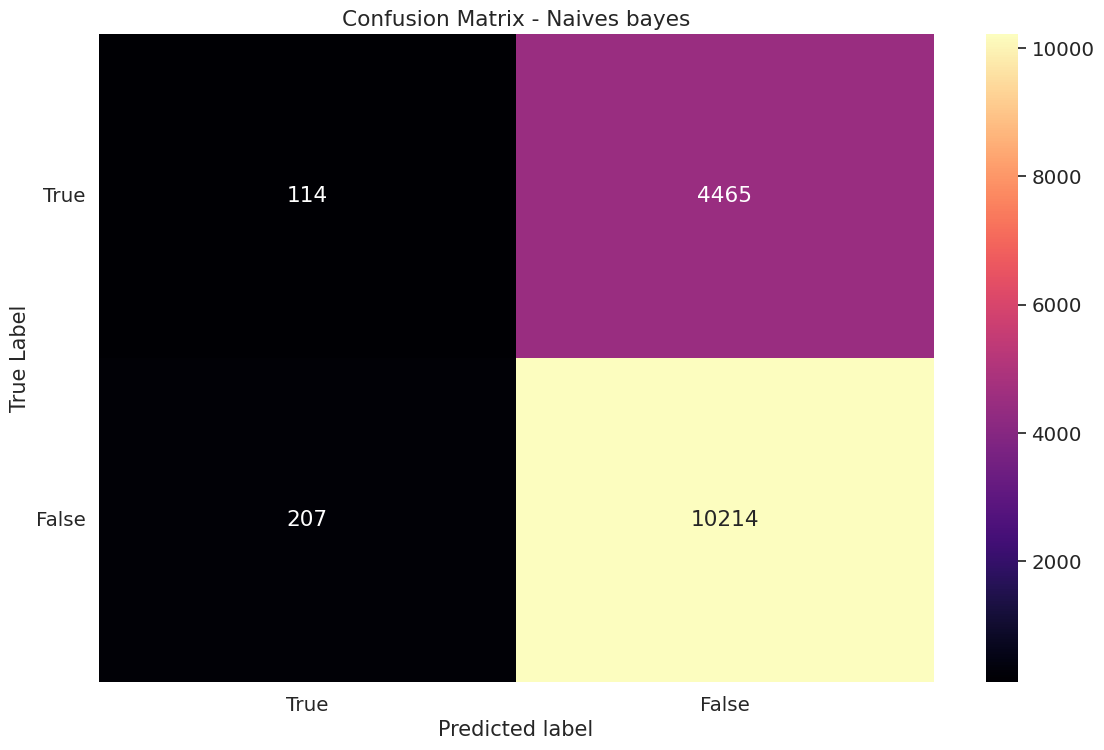

<Figure size 1000x700 with 0 Axes>

0.5025162644373136

In [24]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
nb_cr = classification_report(y_test, y_pred)
print('Naive Bayes      Classification Report \n')
print(nb_cr)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(confusion_matrix)#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")#set axis titles
ax.set_title('Confusion Matrix - Naives Bayes')
ax.set_xlabel("True label", fontsize =15)
ax.set_xticklabels(['True', 'False'])
ax.set_ylabel("Predicted Label", fontsize=15)
ax.set_yticklabels(['True', 'False'], rotation = 0)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

Accuracy: 0.6946666666666667
LogisticRegression    Classification Report 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4579
           1       0.69      1.00      0.82     10421

    accuracy                           0.69     15000
   macro avg       0.35      0.50      0.41     15000
weighted avg       0.48      0.69      0.57     15000



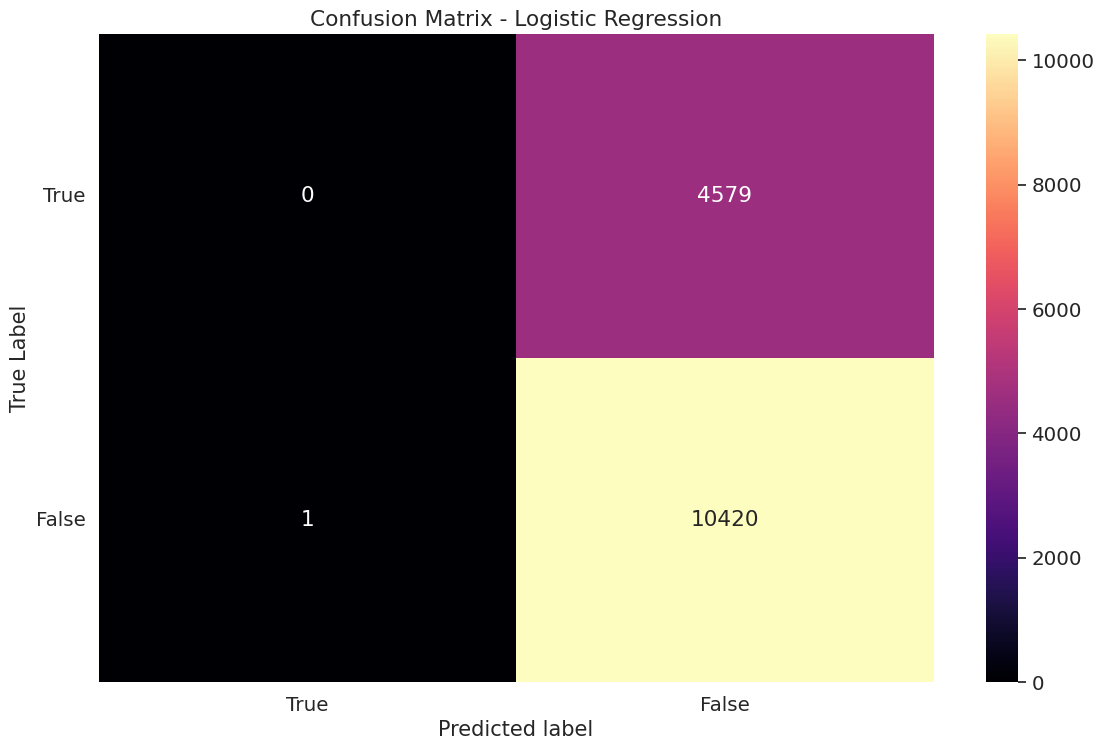

<Figure size 1000x700 with 0 Axes>

0.4999520199596968

In [25]:
from sklearn.linear_model import LogisticRegression

Log = LogisticRegression(random_state=0).fit(X_train, y_train)
Log.predict(X_test)
Log.score(X_test, y_test)
y_pred = Log.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
nb_cr = classification_report(y_test, y_pred)
print('LogisticRegression    Classification Report \n')
print(nb_cr)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(confusion_matrix)#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")#set axis titles
ax.set_title('Confusion Matrix - Logistic Regression')
ax.set_xlabel("True label", fontsize =15)
ax.set_xticklabels(['True', 'False'])
ax.set_ylabel("Predicted Label", fontsize=15)
ax.set_yticklabels(['True', 'False'], rotation = 0)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

Accuracy: 0.6947333333333333
RandomForestClassifier      Classification Report 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4579
           1       0.69      1.00      0.82     10421

    accuracy                           0.69     15000
   macro avg       0.35      0.50      0.41     15000
weighted avg       0.48      0.69      0.57     15000



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


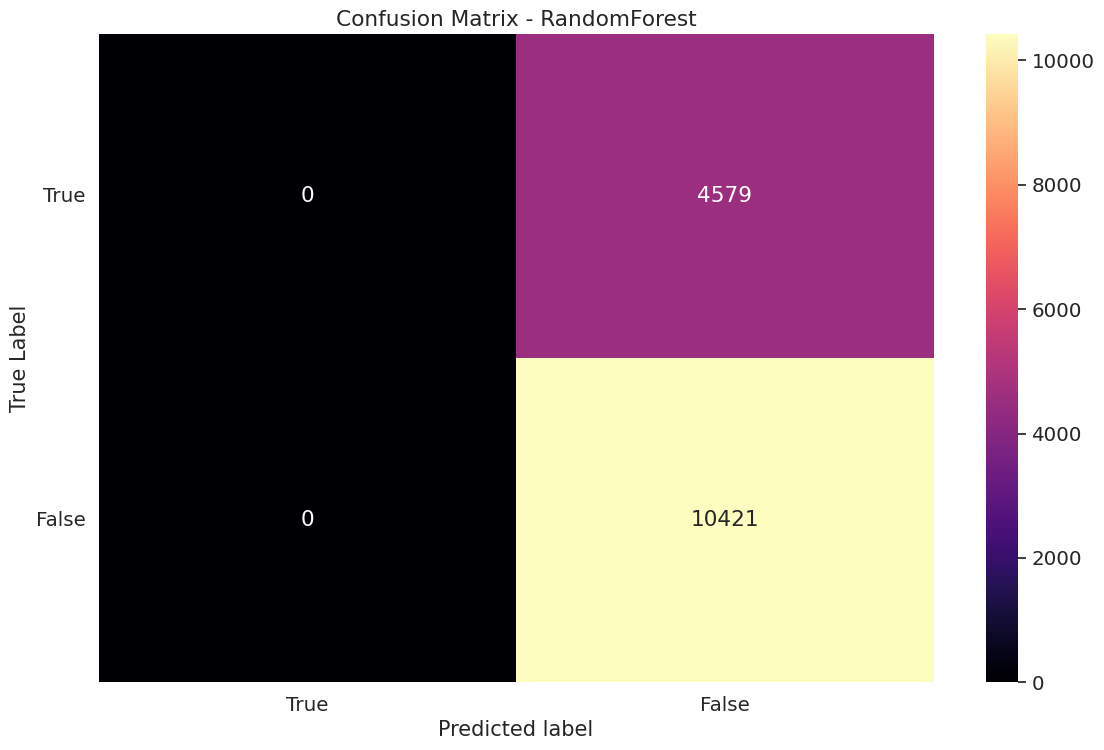

<Figure size 1000x700 with 0 Axes>

0.5

In [26]:
# Try random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
nb_cr = classification_report(y_test, y_pred)
print('RandomForestClassifier      Classification Report \n')
print(nb_cr)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(confusion_matrix)#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")#set axis titles
ax.set_title('Confusion Matrix - Random Forest')
ax.set_xlabel("True label", fontsize =15)
ax.set_xticklabels(['True', 'False'])
ax.set_ylabel("Predicted Label", fontsize=15)
ax.set_yticklabels(['True', 'False'], rotation = 0)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

In [27]:
# find the learning rate for adaboost
crossvalidation = KFold(n_splits = 10,shuffle = True,random_state = 1)
ada = AdaBoostClassifier()
search_grid = {'n_estimators':[100,200,300],'learning_rate':[.05,.1,.5,1]}
search = GridSearchCV(estimator = ada, param_grid = search_grid,scoring = 'accuracy',n_jobs = 1,cv = crossvalidation)

computationally intensive 

Accuracy: 0.7329333333333333
AdaBoostClassifier   Classification Report 

              precision    recall  f1-score   support

           0       0.62      0.33      0.43      4579
           1       0.76      0.91      0.83     10421

    accuracy                           0.73     15000
   macro avg       0.69      0.62      0.63     15000
weighted avg       0.71      0.73      0.70     15000



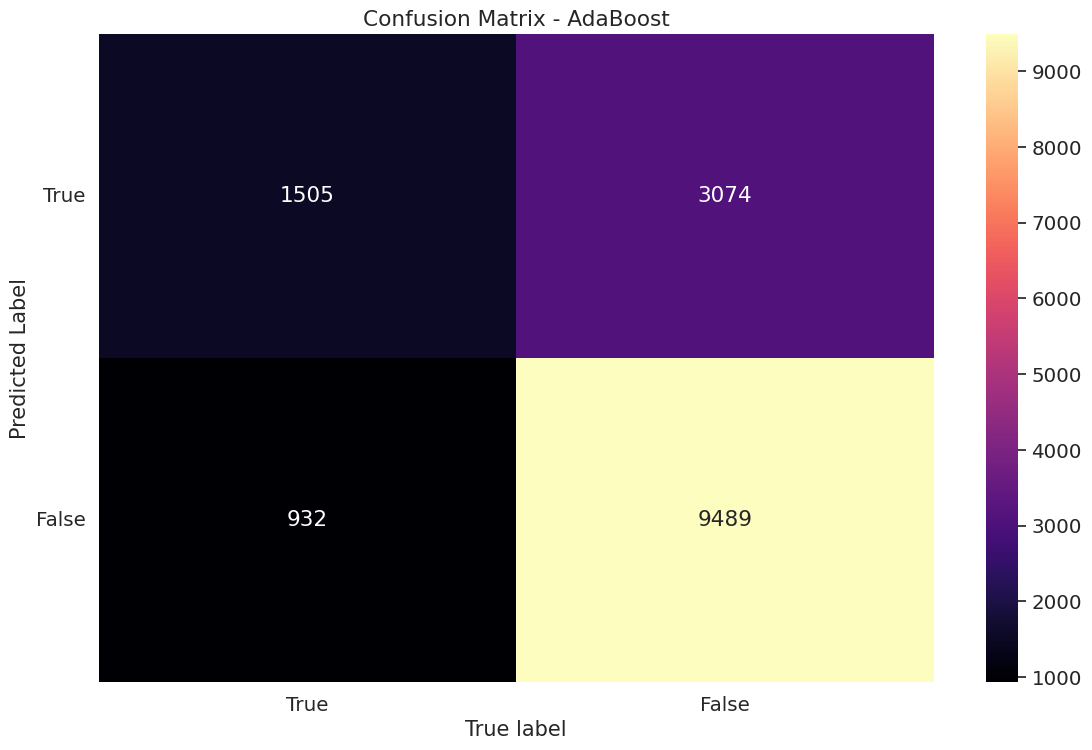

<Figure size 1000x700 with 0 Axes>

0.5

In [30]:
# try adaboost with n_estimators = 150
abc1 = AdaBoostClassifier(n_estimators = 150, learning_rate = .1, random_state = 1)

# Train Adaboost classifier
model1 = abc1.fit(X_train, y_train)

#Predict the response for test dataset
y_pred1 = model1.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred1))
nb_cr = classification_report(y_test, y_pred1)
print('AdaBoostClassifier   Classification Report \n')
print(nb_cr)


confusion_matrix = metrics.confusion_matrix(y_test, y_pred1)
matrix_df = pd.DataFrame(confusion_matrix)#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")#set axis titles
ax.set_title('Confusion Matrix - AdaBoost')
ax.set_xlabel("True label", fontsize =15)
ax.set_xticklabels(['True', 'False'])
ax.set_ylabel("Predicted Label", fontsize=15)
ax.set_yticklabels(['True', 'False'], rotation = 0)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

Accuracy: 0.7331333333333333
AdaBoostClassifier   Classification Report 

              precision    recall  f1-score   support

           0       0.62      0.32      0.42      4579
           1       0.75      0.91      0.83     10421

    accuracy                           0.73     15000
   macro avg       0.69      0.62      0.62     15000
weighted avg       0.71      0.73      0.70     15000



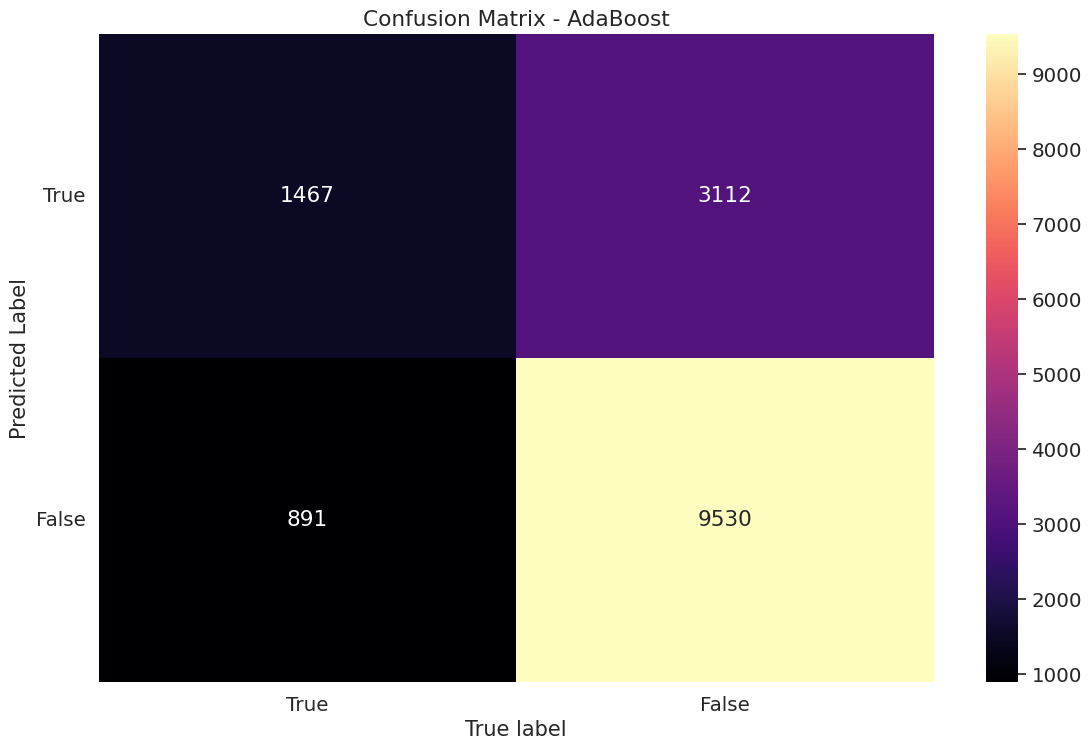

<Figure size 1000x700 with 0 Axes>

0.6174375980229918

In [31]:
# try n_estimator=300 on adaboost
abc2 = AdaBoostClassifier(n_estimators = 300, learning_rate = .1, random_state = 1)

# Train Adaboost classifier
model2 = abc2.fit(X_train, y_train)

#Predict the response for test dataset
y_pred2 = model2.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))
nb_cr = classification_report(y_test, y_pred2)
print('AdaBoostClassifier   Classification Report \n')
print(nb_cr)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred2)
matrix_df = pd.DataFrame(confusion_matrix)#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")#set axis titles
ax.set_title('Confusion Matrix - AdaBoost')
ax.set_xlabel("True label", fontsize =15)
ax.set_xticklabels(['True', 'False'])
ax.set_ylabel("Predicted Label", fontsize=15)
ax.set_yticklabels(['True', 'False'], rotation = 0)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

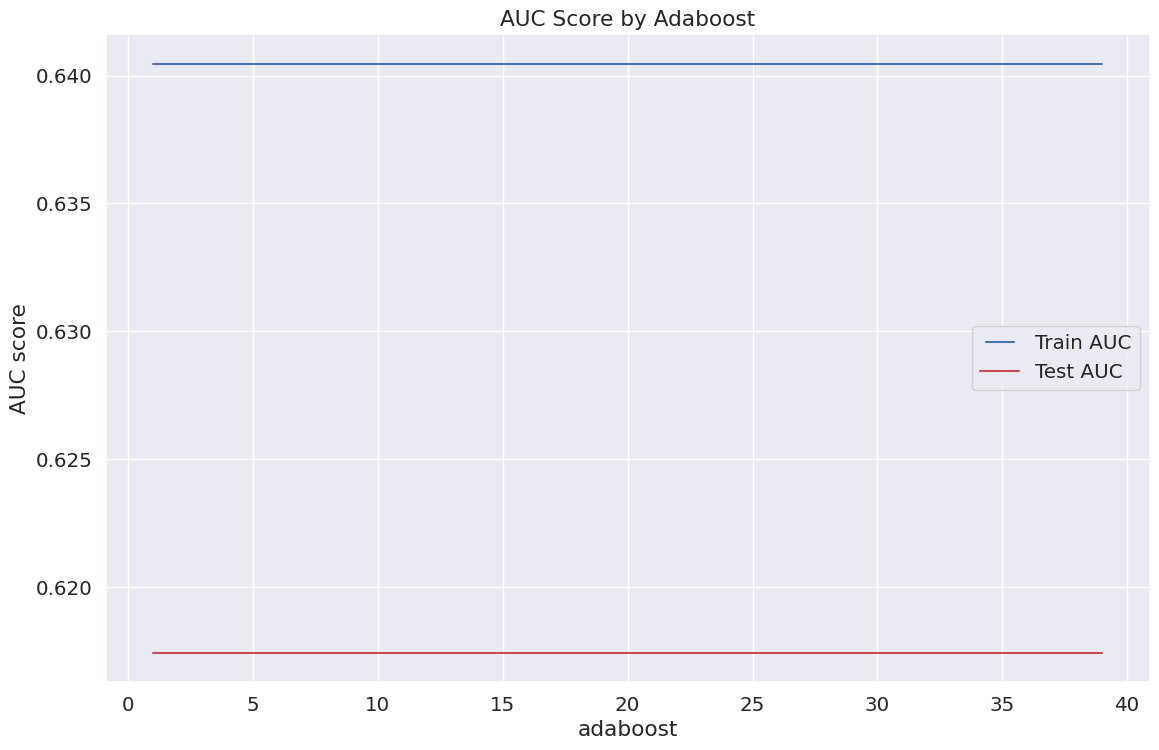

In [34]:
# LOOKING AT THE AUC_SCORE TO SEE IF THERE COULD BE UNDERFITTING
neighbors = list(range(1,40))

train_results = []
test_results = []

for n in neighbors:
    model = AdaBoostClassifier(n_estimators = 300, learning_rate = .1, random_state = 1)
    model.fit(X_train, y_train)
    train_pred1 = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred2 = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred2)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(neighbors, train_results, 'b', label = "Train AUC")
line2, = plt.plot(neighbors, test_results, 'r', label = "Test AUC")
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('AUC score')
plt.xlabel('adaboost')
plt.title('AUC Score by Adaboost')
plt.show()